In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import OrderedDict
from Utilities.plotting import mkdir  
from Utilities.plotting import save_gif
from Utilities.plotting import plot_nn_result  
from Utilities.plotting import plot_pinn_result  
from IPython.display import Image

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
def oscillator(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

torch.Size([2000, 1]) torch.Size([2000, 1])


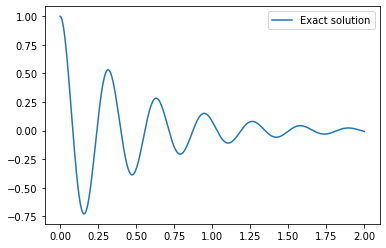

In [4]:
d, w0 = 2, 20

# get the analytical solution over the full domain
N_f = 2000
t = torch.linspace(0,2,N_f).view(-1,1)
u = oscillator(d, w0, t).view(-1,1)
print(t.shape, u.shape)

plt.figure()
plt.plot(t, u, label="Exact solution")
plt.legend()
plt.show()

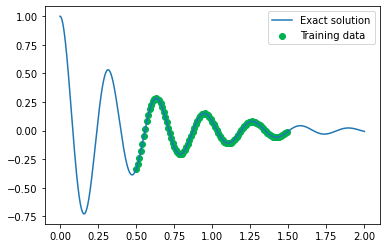

In [5]:
t_data= t[:1000:10]
u_data= u[:1000:10]
plt.figure()
plt.plot(t, u, label="Exact solution")
plt.scatter(t_data, u_data, color="#00B050", label="Training data")
plt.legend()
plt.show()


In [6]:
N_train = len(t_data)
idx = np.random.choice(t_data.shape[0], N_train, replace=False)
len(idx)

100

In [7]:
t_train = t_data[idx,:].detach().requires_grad_(True).float().to(device)
u_train = u_data[idx,:].detach().requires_grad_(True).float().to(device)
t_cuda = torch.clone(t).to(device)

In [12]:
class LSTM(nn.Module):
    def __init__(self, hidden_layers=64,outputs=1 ):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, outputs)
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.hidden_layers, dtype=torch.float32)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(input_t, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs

In [13]:
model = LSTM()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
files_pinn = []

In [14]:
model 

LSTM(
  (lstm1): LSTMCell(1, 64)
  (lstm2): LSTMCell(64, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
%%time
for i in range(nIter):

    model.dnn.optimizer_Adam.zero_grad()

    # compute the "data loss"
    physics , u_pred , u_t , u_tt = model.net_f(t_train)
    
    
    # use mean squared error (MSE)
    loss_u = torch.mean((u_train - u_pred)**2)
    
    # compute the "physics loss"
    loss_pde = (1e-4)*torch.mean(physics**2)
    loss = loss_u + loss_pde +  loss_ci + loss_ci2

    # backpropagate joint loss
    loss.backward()

    model.dnn.optimizer_Adam.step()

    # plot the result as training progresses
    if (model.dnn.iter+1) % 600 == 0:

        u_pred = model.predict(t_cuda).detach().cpu().numpy()

        plot_nn_result(t,u,t_data,u_data,u_pred,model.dnn.iter)

        file = "plots/pinn/pinn_%.8i.png"%(model.dnn.iter + 1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files_pinn.append(file)
        
        if (model.dnn.iter+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
    #update iteration 
    model.dnn.iter += 1